In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

Data Understanding

In [2]:
df = pd.read_csv("C:/Users/bayyi/OneDrive/Documents/NLP/CLUSTERING/klasifikasi_berita.csv",on_bad_lines="skip", sep=";")

In [3]:
df.head()

,content,tags,title,kategori
0,baru dua tahun diberlakukan aturan mengenai ke...,"akuisisi bank,perbankan",masalah pelonggaran kepemilikan bank,ekonomi
1,tempoco jakarta kepala badan kepegawaian daer...,"anies,anies baswedan,gubernur dki jakarta",dki jelaskan kepgub anies soal tambahan pengha...,ekonomi
2,pt aneka tambang tbk atau membuka pelayanan t...,"antam,emas,whatsapp",cegah covid19 antam layani transaksi emas via ...,ekonomi
3,anggaran pendapatan dan belanja daerah atau k...,"apbd,kota bekasi,dprd kota bekasi",rancangan apbd kota bekasi 2020 proyeksi penda...,ekonomi
4,ketua umum asosiasi pengusaha indonesia atau a...,"avtur,apindo,bumn",apindo swasta belum jual avtur karena diganjal...,ekonomi


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   1996 non-null   object
 1   tags      2000 non-null   object
 2   title     2000 non-null   object
 3   kategori  2000 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [5]:
df.isna().sum()

content     4
tags        0
title       0
kategori    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1996 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   1996 non-null   object
 1   tags      1996 non-null   object
 2   title     1996 non-null   object
 3   kategori  1996 non-null   object
dtypes: object(4)
memory usage: 78.0+ KB


Data Pre-Processing

In [8]:
def clean_text(text):
    # Hanya buang karakter yang bukan huruf dan spasi
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

df['content'] = df['content'].astype(str).apply(clean_text)

In [9]:
print(df['content'].head())

0    baru dua tahun diberlakukan aturan mengenai ke...
1    tempoco jakarta kepala badan kepegawaian daera...
2    pt aneka tambang tbk atau membuka pelayanan tr...
3    anggaran pendapatan dan belanja daerah atau ko...
4    ketua umum asosiasi pengusaha indonesia atau a...
Name: content, dtype: object


In [10]:
df['kategori'].value_counts()

kategori
peristiwa             369
politik               312
olahraga              288
hiburan               214
internasional         202
hukum dan kriminal    187
ekonomi               154
gaya hidup            122
otomotif               67
kesehatan              49
teknologi              31
politk                  1
Name: count, dtype: int64

In [11]:
df['kategori'] = df['kategori'].replace({'politk': 'politik'})

In [12]:
df['kategori'].value_counts()

kategori
peristiwa             369
politik               313
olahraga              288
hiburan               214
internasional         202
hukum dan kriminal    187
ekonomi               154
gaya hidup            122
otomotif               67
kesehatan              49
teknologi              31
Name: count, dtype: int64

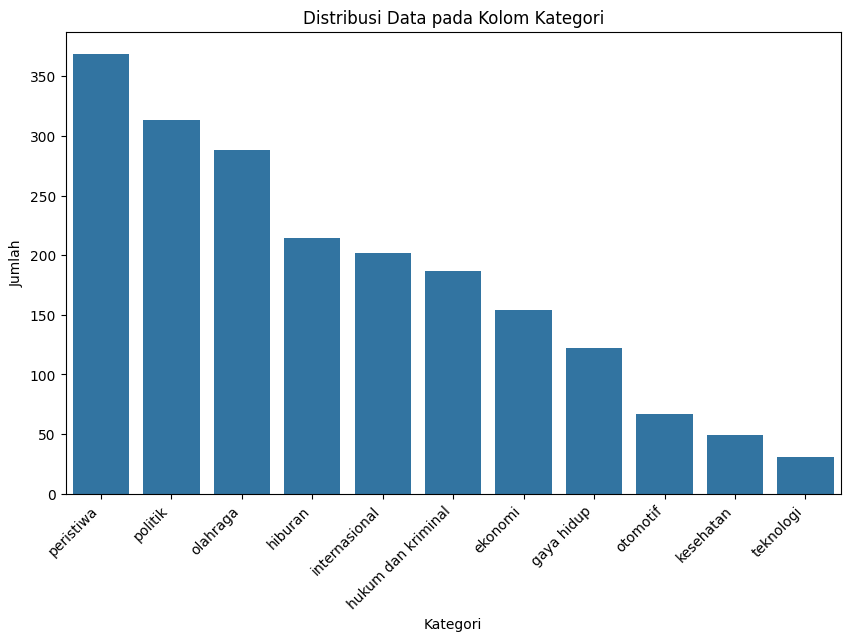

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='kategori', order=df['kategori'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Distribusi Data pada Kolom Kategori')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()

Tokenisasi

In [14]:
df['content_token']= df['content'].apply(word_tokenize)
df['title_token']= df['title'].apply(word_tokenize)

In [15]:
df[['content_token', 'title_token']].head()

,content_token,title_token
0,"[baru, dua, tahun, diberlakukan, aturan, menge...","[masalah, pelonggaran, kepemilikan, bank]"
1,"[tempoco, jakarta, kepala, badan, kepegawaian,...","[dki, jelaskan, kepgub, anies, soal, tambahan,..."
2,"[pt, aneka, tambang, tbk, atau, membuka, pelay...","[cegah, covid19, antam, layani, transaksi, ema..."
3,"[anggaran, pendapatan, dan, belanja, daerah, a...","[rancangan, apbd, kota, bekasi, 2020, proyeksi..."
4,"[ketua, umum, asosiasi, pengusaha, indonesia, ...","[apindo, swasta, belum, jual, avtur, karena, d..."


In [16]:
print(df[['content', 'content_token']].head())

                                             content  \
0  baru dua tahun diberlakukan aturan mengenai ke...   
1  tempoco jakarta kepala badan kepegawaian daera...   
2  pt aneka tambang tbk atau membuka pelayanan tr...   
3  anggaran pendapatan dan belanja daerah atau ko...   
4  ketua umum asosiasi pengusaha indonesia atau a...   

                                       content_token  
0  [baru, dua, tahun, diberlakukan, aturan, menge...  
1  [tempoco, jakarta, kepala, badan, kepegawaian,...  
2  [pt, aneka, tambang, tbk, atau, membuka, pelay...  
3  [anggaran, pendapatan, dan, belanja, daerah, a...  
4  [ketua, umum, asosiasi, pengusaha, indonesia, ...  


In [17]:
df['gabung_tokens'] = df.apply(lambda row: row['title_token'] + row['content_token'], axis=1)

Stopwords Removal

In [18]:
stopwords = set(StopWordRemoverFactory().get_stop_words())

In [19]:
df['tokens_clean'] = df['gabung_tokens'].apply(lambda x: [word for word in x if word not in stopwords])

In [20]:
df['text_clean'] = df['tokens_clean'].apply(lambda x: ' '.join(x))

C:\Users\bayyi\AppData\Local\Temp\ipykernel_24700\2941269327.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


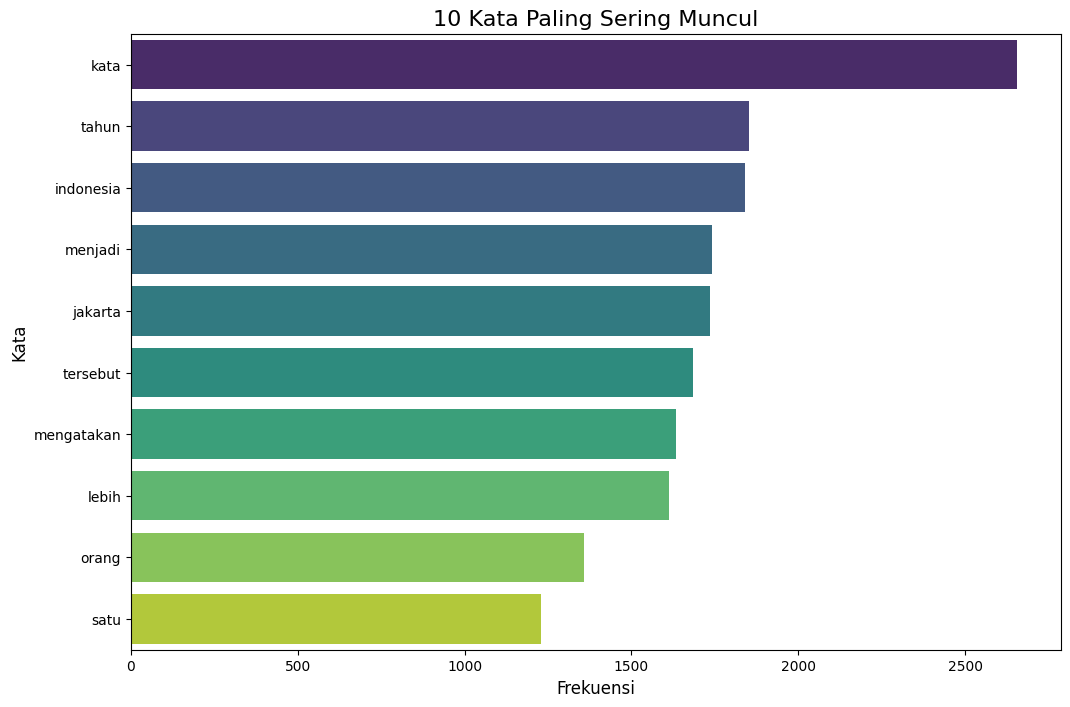

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

factory = StopWordRemoverFactory()
indonesian_stopwords = factory.get_stop_words()

count_vectorizer = CountVectorizer(stop_words=indonesian_stopwords)
word_counts = count_vectorizer.fit_transform(df['text_clean'])

word_freq = Counter(dict(zip(count_vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1)))

most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 8))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title("10 Kata Paling Sering Muncul", fontsize=16)
plt.xlabel("Frekuensi", fontsize=12)
plt.ylabel("Kata", fontsize=12)
plt.show()

Label Encoding

In [22]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['kategori'])

In [23]:
kategori_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(kategori_mapping)

{'ekonomi': np.int64(0), 'gaya hidup': np.int64(1), 'hiburan': np.int64(2), 'hukum dan kriminal': np.int64(3), 'internasional': np.int64(4), 'kesehatan': np.int64(5), 'olahraga': np.int64(6), 'otomotif': np.int64(7), 'peristiwa': np.int64(8), 'politik': np.int64(9), 'teknologi': np.int64(10)}


In [24]:
"""
{'ekonomi': np.int64(0), 
'gaya hidup': np.int64(1), 
'hiburan': np.int64(2), 
'hukum dan kriminal': np.int64(3), 
'internasional': np.int64(4), 
'kesehatan': np.int64(5), 
'olahraga': np.int64(6), 
'otomotif': np.int64(7), 
'peristiwa': np.int64(8), 
'politik': np.int64(9), 
'teknologi': np.int64(10)}
"""

"\n{'ekonomi': np.int64(0), \n'gaya hidup': np.int64(1), \n'hiburan': np.int64(2), \n'hukum dan kriminal': np.int64(3), \n'internasional': np.int64(4), \n'kesehatan': np.int64(5), \n'olahraga': np.int64(6), \n'otomotif': np.int64(7), \n'peristiwa': np.int64(8), \n'politik': np.int64(9), \n'teknologi': np.int64(10)}\n"

TF - IDF

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(df['text_clean'])
y = df['label_encoded']

In [26]:
print(len(vectorizer.get_feature_names_out()))

336533


In [27]:
print(X.shape)

(1996, 336533)


## SVC Linear

In [28]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.svm import LinearSVC

Pembagian 80 : 20

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Distribusi label setelah resampling:", Counter(y_train_resampled))

Distribusi label setelah resampling: Counter({9: 295, 8: 295, 1: 295, 7: 295, 2: 295, 4: 295, 3: 295, 0: 295, 6: 295, 5: 295, 10: 295})


In [30]:
model = LinearSVC()
model.fit(X_train_resampled, y_train_resampled)

LinearSVC()

In [31]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Akurasi: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Akurasi: 0.6950

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.70        31
           1       0.84      0.88      0.86        24
           2       0.78      0.65      0.71        43
           3       0.61      0.51      0.56        37
           4       0.75      0.51      0.61        41
           5       0.50      0.40      0.44        10
           6       0.89      0.97      0.93        58
           7       0.53      0.62      0.57        13
           8       0.63      0.62      0.63        74
           9       0.62      0.76      0.68        63
          10       0.60      0.50      0.55         6

    accuracy                           0.69       400
   macro avg       0.67      0.65      0.66       400
weighted avg       0.70      0.69      0.69       400



In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24  0  0  0  0  0  0  0  1  6  0]
 [ 0 21  1  0  0  1  0  1  0  0  0]
 [ 0  1 28  1  1  1  1  0  7  3  0]
 [ 0  1  0 19  0  0  0  0  6 10  1]
 [ 3  0  5  0 21  0  3  4  4  1  0]
 [ 0  1  0  0  2  4  0  0  3  0  0]
 [ 0  0  0  0  0  0 56  1  0  1  0]
 [ 2  0  0  0  0  0  1  8  1  0  1]
 [ 4  1  2  4  4  2  1  1 46  9  0]
 [ 5  0  0  6  0  0  1  0  3 48  0]
 [ 0  0  0  1  0  0  0  0  2  0  3]]


Menggunakan GridSearch

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 3000]
}

svc = LinearSVC(random_state=42)

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.1s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.1s
[CV] END ...........C=0.01, class_weight=None, max_iter=2000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=2000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=2000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, max_iter=2000; total time=   0.1s
[CV] END ...........C=0.01, class_weight=None, max_iter=2000; total time=   0.1s
[CV] END ...........C=0.01, class_weight=None, max_iter=3000; total time=   0.2s
[CV] END ...........C=0.01, class_weight=None, 

In [34]:
best_svc = LinearSVC(C=1, class_weight= 'balanced', max_iter=1000)
best_svc.fit(X_train_resampled, y_train_resampled)

LinearSVC(C=1, class_weight='balanced')

In [35]:
y_pred = best_svc.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.695
              precision    recall  f1-score   support

           0       0.63      0.77      0.70        31
           1       0.84      0.88      0.86        24
           2       0.78      0.65      0.71        43
           3       0.61      0.51      0.56        37
           4       0.75      0.51      0.61        41
           5       0.50      0.40      0.44        10
           6       0.89      0.97      0.93        58
           7       0.53      0.62      0.57        13
           8       0.63      0.62      0.63        74
           9       0.62      0.76      0.68        63
          10       0.60      0.50      0.55         6

    accuracy                           0.69       400
   macro avg       0.67      0.65      0.66       400
weighted avg       0.70      0.69      0.69       400



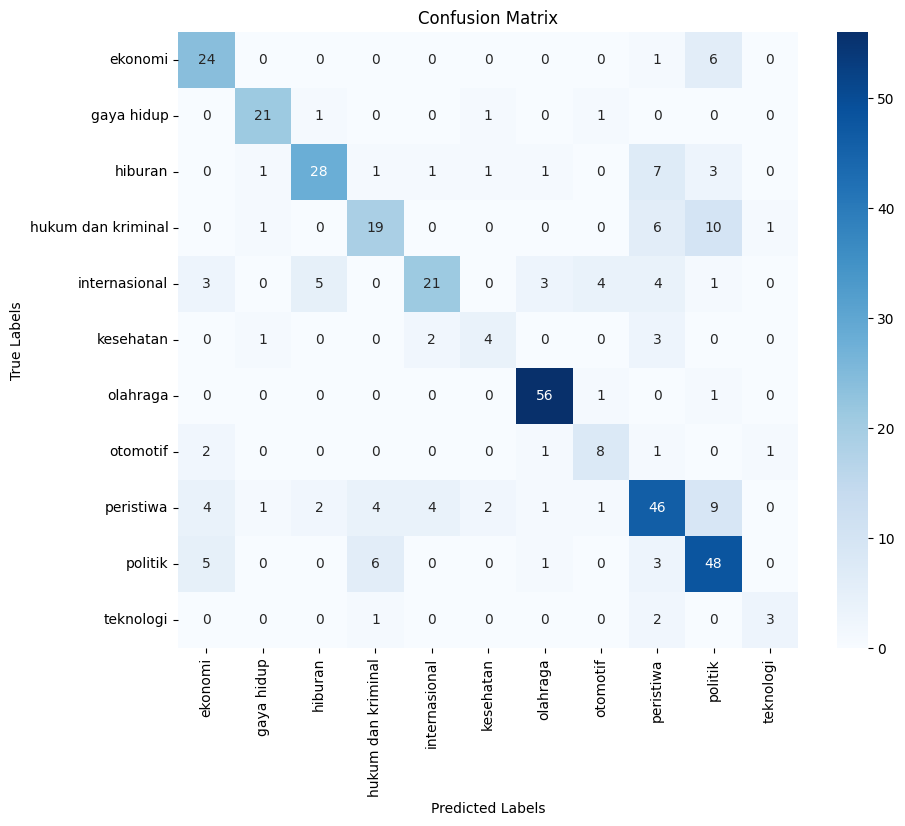

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=kategori_mapping.keys(), yticklabels=kategori_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Simpan Model

In [37]:
import joblib

In [38]:
joblib.dump(model, 'model_svc_baru.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer_baru.pkl')

['tfidf_vectorizer_baru.pkl']

In [39]:
#load model
loaded_model = joblib.load('model_svc_baru.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer_baru.pkl')

In [40]:
label_map = {
    0: "ekonomi",
    1: "gaya hidup",
    2: "hiburan",
    3: "hukum dan kriminal",
    4: "internasional",
    5: "kesehatan",
    6: "olahraga",
    7: "otomotif",
    8: "peristiwa",
    9: "politik",
    10: "teknologi"
}


In [41]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # hapus tanda baca
    text = re.sub(r'\d+', '', text)      # hapus angka
    text = text.strip()
    return text

def predict_news_category(text):
    cleaned_text = clean_text(text)
    tfidf = vectorizer.transform([cleaned_text])
    prediction = model.predict(tfidf)
    return label_map[prediction[0]]  

In [42]:
berita_baru = "seventeen menggelar konser di jakarta pada bulan depan"
kategori = predict_news_category(berita_baru)
print(f"Kategori Berita: {kategori}")

Kategori Berita: hiburan


Mendapatkan Rekomendasi

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tabulate import tabulate

In [44]:
def prediksi_kategori(artikel_baru):
    artikel_vector = loaded_vectorizer.transform([artikel_baru])
    pred_numeric = loaded_model.predict(artikel_vector)
    kategori_prediksi = le.inverse_transform([int(pred_numeric[0])])[0]
    return kategori_prediksi

def rekomendasi_artikel(artikel_baru, top_n=3):
    kategori_prediksi = prediksi_kategori(artikel_baru)
    artikel_vector = loaded_vectorizer.transform([artikel_baru])
    tfidf_matrix = loaded_vectorizer.transform(df['title']) 
    cosine_similarities = cosine_similarity(artikel_vector, tfidf_matrix).flatten()

    kategori_sama_indices = df[df['kategori'] == kategori_prediksi].index.tolist()

    if not kategori_sama_indices:
        print(f"Tidak ditemukan artikel dengan kategori: {kategori_prediksi}")
        return kategori_prediksi, pd.DataFrame()

    kategori_sama_tfidf_indices = [df.index.get_loc(i) for i in kategori_sama_indices]
    kategori_sama_similarities = [(i, cosine_similarities[i]) for i in kategori_sama_tfidf_indices]
    kategori_sama_similarities.sort(key=lambda x: x[1], reverse=True)

    similar_indices = [i[0] for i in kategori_sama_similarities[:top_n]]

    rekomendasi_df = pd.DataFrame([
        {
            "Kategori": df.iloc[i]['kategori'],
            "Judul Artikel": df.iloc[i]['title'],
            "Cuplikan Konten": df.iloc[i]['content'][:100] + "..." if len(df.iloc[i]['content']) > 100 else df.iloc[i]['content'],
            "Cosine Similarity": cosine_similarities[i]
        }
        for i in similar_indices
    ])

    return kategori_prediksi, rekomendasi_df

In [45]:
artikel_input = "banjir di jakarta menyebabkan banyak kerugian bagi masyarakat"
kategori, rekomendasi_df = rekomendasi_artikel(artikel_input, top_n=3)

print(f"\nKategori Prediksi: {kategori}\n")
if not rekomendasi_df.empty:
    print(tabulate(rekomendasi_df, headers='keys', tablefmt='grid'))
else:
    print("Tidak ada artikel serupa ditemukan.")


Kategori Prediksi: peristiwa

+----+------------+-------------------------------------------------+---------------------------------------------------------------------------------------------------------+---------------------+
|    | Kategori   | Judul Artikel                                   | Cuplikan Konten                                                                                         |   Cosine Similarity |
+====+============+=================================================+=========================================================================================================+=====================+
|  0 | peristiwa  | bnpb banjir di jabodetabek hari ini             | hujan lebat di jakarta dan sekitarnya selasa malam desember sampai rabu pagi januari menyebabkan di ... |           0.116823  |
+----+------------+-------------------------------------------------+---------------------------------------------------------------------------------------------------------+--

In [46]:
artikel_input = "covid 19 sudah mulai mereda di indonesia"
kategori, rekomendasi_df = rekomendasi_artikel(artikel_input, top_n=3)

print(f"\nKategori Prediksi: {kategori}\n")
if not rekomendasi_df.empty:
    print(tabulate(rekomendasi_df, headers='keys', tablefmt='grid'))
else:
    print("Tidak ada artikel serupa ditemukan.")


Kategori Prediksi: peristiwa

+----+------------+----------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+---------------------+
|    | Kategori   | Judul Artikel                                                  | Cuplikan Konten                                                                                         |   Cosine Similarity |
+====+============+================================================================+=========================================================================================================+=====================+
|  0 | peristiwa  | lapindo brantas tagih balik piutang 19 t ini respons kemenkeu  | kementerian keuangan atau kemenkeu bakal mengecek soal kabar bahwa brantas inc dan pt minarak lapind... |            0.209078 |
+----+------------+----------------------------------------------------------------+---------------------------------

## Perbandingan ALgoritma

In [47]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestClassifier

# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Random Forest": RandomForestClassifier(),
#     "Naive Bayes": MultinomialNB(),
#     "XGBoost" : XGBClassifier(),
# }

# for name, model in models.items():
#     model.fit(X_train_resampled, y_train_resampled)
#     y_pred = model.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     print(f"{name} Accuracy: {acc:.4f}")

In [48]:
#simpan label encoder
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [49]:
#simpan dataset yang sudah dibersihkan
df.to_csv('dataset_cleaned.csv', index=False, sep=';')